# IllusTrip: Text to Video 3D

Part of [Aphantasia](https://github.com/eps696/aphantasia) suite, made by Vadim Epstein [[eps696](https://github.com/eps696)]  
Based on [CLIP](https://github.com/openai/CLIP) + FFT/pixel ops from [Lucent](https://github.com/greentfrapp/lucent). 
3D part by [deKxi](https://twitter.com/deKxi), based on [AdaBins](https://github.com/shariqfarooq123/AdaBins) depth.  
thanks to [Ryan Murdock](https://twitter.com/advadnoun), [Jonathan Fly](https://twitter.com/jonathanfly), [@eduwatch2](https://twitter.com/eduwatch2) for ideas.

## Features 
* continuously processes **multiple sentences** (e.g. illustrating lyrics or poems)
* makes **videos**, evolving with pan/zoom/rotate motion
* works with [inverse FFT](https://github.com/greentfrapp/lucent/blob/master/lucent/optvis/param/spatial.py) representation of the image or **directly with RGB** pixels (no GANs involved)
* generates massive detailed textures (a la deepdream), **unlimited resolution**
* optional **depth** processing for 3D look
* various CLIP models
* can start/resume from an image


**Run the cell below after each session restart**

Ensure that you're given Tesla T4/P4/P100 GPU. With Tesla K80 it will be ~8x slower.

In [ ]:
#@title General setup

!pip install ftfy==5.8 transformers
!pip install gputil ffpb 

# !apt-get -qq install ffmpeg
work_dir = '/content/illustrip'
import os
os.makedirs(work_dir, exist_ok=True)
%cd $work_dir

import os
import io
import time
import math
import random
import imageio
import numpy as np
import PIL
from base64 import b64encode
import shutil
from easydict import EasyDict as edict
a = edict()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torch.autograd import Variable

from IPython.display import HTML, Image, display, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import ipywidgets as ipy
from google.colab import output, files

import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/openai/CLIP.git --no-deps
import clip
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
!pip install kornia
import kornia
!pip install lpips
import lpips
!pip install PyWavelets==1.1.1
!pip install git+https://github.com/fbcotter/pytorch_wavelets

!pip install git+https://github.com/eps696/aphantasia
from aphantasia.image import to_valid_rgb, fft_image, rfft2d_freqs, img2fft, pixel_image, un_rgb
from aphantasia.utils import basename, file_list, img_list, img_read, txt_clean, plot_text, old_torch
from aphantasia.utils import slice_imgs, derivat, pad_up_to, slerp, checkout, sim_func, latent_anima
from aphantasia import transforms
from aphantasia.progress_bar import ProgressIPy as ProgressBar

%cd $work_dir
!git clone https://github.com/eps696/aphantasia --recursive
work_dir = os.path.join(work_dir, 'aphantasia')
%cd $work_dir
from depth import depth
# !wget https://github.com/eps696/aphantasia/blob/master/mask.jpg?raw=true -O mask.jpg
depth_mask_file = os.path.join(work_dir, 'depth', 'mask.jpg')
%cd /content

clear_output()

def save_img(img, fname=None):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1,2,0))  
  img = np.clip(img*255, 0, 255).astype(np.uint8)
  if fname is not None:
    imageio.imsave(fname, np.array(img))
    imageio.imsave('result.jpg', np.array(img))

def makevid(seq_dir, size=None):
  char_len = len(basename(img_list(seq_dir)[0]))
  out_sequence = seq_dir + '/%0{}d.jpg'.format(char_len)
  out_video = seq_dir + '.mp4'
  print('.. generating video ..')
  !ffmpeg -y -v warning -i $out_sequence -crf 18 $out_video
  data_url = "data:video/mp4;base64," + b64encode(open(out_video,'rb').read()).decode()
  wh = '' if size is None else 'width=%d height=%d' % (size, size)
  return """<video %s controls><source src="%s" type="video/mp4"></video>""" % (wh, data_url)

# Hardware check
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import GPUtil as GPU
gpu = GPU.getGPUs()[0] # XXX: only one GPU on Colab and isn’t guaranteed
!nvidia-smi -L
print("GPU RAM {0:.0f}MB | Free {1:.0f}MB)".format(gpu.memoryTotal, gpu.memoryFree))

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-dc2787d1-beaf-f08e-878e-cbfb35d9f857)
GPU RAM 16160MB | Free 16158MB)


In [ ]:
#@title Load inputs

#@markdown **Content** (either type a text string, or upload a text file):
content = "Sunflowers Nightingale Ukraine" #@param {type:"string"}
upload_texts = False #@param {type:"boolean"}

#@markdown **Style** (either type a text string, or upload a text file):
style = "bliss" #@param {type:"string"}
upload_styles = False #@param {type:"boolean"}

#@markdown For non-English languages use Google translation:
translate = False #@param {type:"boolean"}

#@markdown Resume from an image (resolution settings below will be ignored in this case): 

if translate:
  !pip3 install googletrans==3.1.0a0
  clear_output()
  from googletrans import Translator
  translator = Translator()

if upload_texts:
  print('Upload main text file')
  uploaded = files.upload()
  text_file = list(uploaded)[0]
  texts = list(uploaded.values())[0].decode().split('\n')
  texts = [tt.strip() for tt in texts if len(tt.strip())>0 and tt[0] != '#']
  print(' main text:', text_file, len(texts), 'lines')
  workname = txt_clean(basename(text_file))
else:
  texts = [content]
  workname = txt_clean(content)[:44]

if upload_styles:
  print('Upload styles text file')
  uploaded = files.upload()
  text_file = list(uploaded)[0]
  styles = list(uploaded.values())[0].decode().split('\n')
  styles = [tt.strip() for tt in styles if len(tt.strip())>0 and tt[0] != '#']
  print(' styles:', text_file, len(styles), 'lines')
else:
  styles = [style]

resume = False #@param {type:"boolean"}
if resume:
  print('Upload file to resume from')
  resumed = files.upload()
  resumed_filename = list(resumed)[0]
  resumed_bytes = list(resumed.values())[0]

assert len(texts) > 0 and len(texts[0]) > 0, 'No input text[s] found!'
tempdir = os.path.join(work_dir, workname)
os.makedirs(tempdir, exist_ok=True)
print('main dir', tempdir)

main dir /content/illustrip/aphantasia/Sunflowers_Nightingale_Ukraine


**`content`** (what to draw) is your primary input; **`style`** (how to draw) is optional, if you want to separate such descriptions.  
If you load text file[s], the imagery will interpolate from line to line (ensure equal line counts for content and style lists, for their accordance).

In [ ]:
#@title Google Drive [optional]

#@markdown Run this cell, if you want to store results on your Google Drive.
using_GDrive = True#@param{type:"boolean"}
if using_GDrive:
  import os
  from google.colab import drive

  if not os.path.isdir('/G/MyDrive'): 
      drive.mount('/G', force_remount=True)
  gdir = '/G/MyDrive'

  tempdir = os.path.join(gdir, 'illustrip', workname)
  os.makedirs(tempdir, exist_ok=True)
  print('main dir', tempdir)


Mounted at /G
main dir /G/MyDrive/illustrip/Sunflowers_Nightingale_Ukraine


In [ ]:
#@title Main settings

sideX = 1280 #@param {type:"integer"}
sideY = 720 #@param {type:"integer"}
steps = 200 #@param {type:"integer"}
frame_step = 100 #@param {type:"integer"}
#@markdown > Config
method = 'RGB' #@param ['FFT', 'RGB']
model = 'ViT-B/32' #@param ['ViT-B/16', 'ViT-B/32', 'RN101', 'RN50x16', 'RN50x4', 'RN50']

# Default settings
if method == 'RGB':
  align = 'overscan'
  colors = 2.3
  contrast = 1.2
  sharpness = -1.
  aug_noise = 0.
  smooth = False
else:
  align = 'uniform'
  colors = 1.8
  contrast = 1.1
  sharpness = 1.
  aug_noise = 2. # only for FFT
  smooth = True
interpolate_topics = True
style_power = 1.
samples = 200
save_step = 1
learning_rate = 1.
optimizer = 'adam'
aug_transform = 'custom'
similarity_function = 'mixed'
macro = 0.4
enforce = 0.
expand = 0.
zoom = 0.012
shift = 10
rotate = 0.8
distort = 0.3
animate_them = True
sample_decrease = 1.
DepthStrength = 0.
save_depth = False

print(' loading CLIP model..')
model_clip, _ = clip.load(model, jit=old_torch())
modsize = model_clip.visual.input_resolution
xmem = {'ViT-B/16':0.25, 'RN50':0.5, 'RN50x4':0.16, 'RN50x16':0.06, 'RN101':0.33}
if model in xmem.keys():
  sample_decrease *= xmem[model]

%cd $work_dir
clear_output()
print(' using CLIP model', model)

if method == 'RGB':

  if resume:
    img_in = imageio.imread(resumed_bytes)
    # params_tmp = torch.Tensor(img_in).permute(2,0,1).unsqueeze(0).float().cuda()
    params_tmp = 3.3 * un_rgb(img_in, colors=2.)
    sideY, sideX = img_in.shape[0], img_in.shape[1]
  else:
    params_tmp = torch.randn(1, 3, sideY, sideX).cuda() # * 0.01

else: # FFT

  if resume:
    if os.path.splitext(resumed_filename)[1].lower()[1:] in ['jpg','png','tif','bmp']:
      img_in = imageio.imread(resumed_bytes)
      params_tmp = img2fft(img_in, 1.5, 1.) * 2.
    else:
      params_tmp = torch.load(io.BytesIO(resumed_bytes))
      if isinstance(params_tmp, list): params_tmp = params_tmp[0]
    params_tmp = params_tmp.cuda()
    sideY, sideX = params_tmp.shape[2], (params_tmp.shape[3]-1)*2
  else:
    params_shape = [1, 3, sideY, sideX//2+1, 2]
    params_tmp = torch.randn(*params_shape).cuda() * 0.01


 using CLIP model ViT-B/32


**`FFT`** method uses inverse FFT representation of the image. It allows flexible motion, but is either blurry (if smoothed) or noisy (if not).  
**`RGB`** method directly optimizes image pixels (without FFT parameterization). It's more clean and stable, when zooming in.  
There are few choices for CLIP `model` (results do vary!). I prefer ViT-B/32 for consistency, next best bet is ViT-B/16.  

**`steps`** defines the length of animation per text line (multiply it to the inputs line count to get total video duration in frames).  
`frame_step` sets frequency of the changes in animation (how many frames between motion keypoints).  



## Other settings [optional]

In [ ]:
#@title Run this cell to override settings, if needed
#@markdown [to roll back defaults, run "Main settings" cell again]

style_power = 1. #@param {type:"number"}
overscan = True #@param {type:"boolean"}
align = 'overscan' if overscan else 'uniform'
interpolate_topics = True #@param {type:"boolean"}

#@markdown > Look
colors = 2.3 #@param {type:"number"}
contrast = 1.2 #@param {type:"number"}
sharpness =  0#@param {type:"number"}

#@markdown > Training
samples = 200 #@param {type:"integer"}
save_step = 1 #@param {type:"integer"}
learning_rate = 1. #@param {type:"number"}
optimizer = 'adam' #@param ['adam', 'adam_custom', 'adamw', 'adamw_custom']

#@markdown > Tricks
aug_transform = 'fast' #@param ['fast', 'custom', 'elastic', 'none']
aug_noise = 0. #@param {type:"number"}
macro = 0.3 #@param {type:"number"}
enforce = 0. #@param {type:"number"}
expand = 0. #@param {type:"number"}
similarity_function = 'mixed' #@param ['cossim', 'spherical', 'mixed', 'angular', 'dot']

#@markdown > Motion
zoom = 0.012 #@param {type:"number"}
shift = 10 #@param {type:"number"}
rotate = 0.8 #@param {type:"number"}
distort = 0.3 #@param {type:"number"}
animate_them = True #@param {type:"boolean"}
smooth = True #@param {type:"boolean"}
if method == 'RGB': smooth = False


`style_power` controls the strength of the style descriptions, comparing to the main input.  
`overscan` provides better frame coverage (needed for RGB method).  
`interpolate_topics` changes the subjects smoothly, otherwise they're switched by cut, making sharper transitions.  

Decrease **`samples`** if you face OOM (it's the main RAM eater), or just to speed up the process (with the cost of quality).  
`save_step` defines, how many optimization steps are taken between saved frames. Set it >1 for stronger image processing.   
Select optimizer: `_custom` options are more stable but noisy; pure `adam` is softer, but may spill some colored blur on longer videos.  
Negative `sharpness` may also reduce noisiness.  

Experimental tricks:  
`aug_transform` applies some augmentations, which quite radically change the output of this method (and slow down the process). Try yourself to see which is good for your case. `aug_noise` augmentation [FFT only!] seems to enhance optimization with transforms.  
`macro` boosts bigger forms.  
`enforce` adds more details by enforcing similarity between two parallel samples.  
`expand` boosts diversity (up to irrelevant) by enforcing difference between prev/next samples.  

Motion section:
`shift` is in pixels, `rotate` in degrees. The values will be used as limits, if you mark `animate_them`.  

`smooth` reduces blinking, but induces motion blur with subtle screen-fixed patterns (valid only for FFT method, disabled for RGB).  

## Add 3D depth [optional]

In [ ]:
# pretrained models: Nyu is much better but Kitti is an option too
depth_model = 'nyu' # @ param ["nyu","kitti"]
DepthStrength = 0.01 #@param{type:"number"}
save_depth = False #@param{type:"boolean"}
MaskBlurAmt = 33 
size = (sideY,sideX)

#@markdown NB: depth computing may double rendering time. 

#@markdown Originally by [deKxi](https://twitter.com/deKxi)

%cd $work_dir

if DepthStrength != 0:

  if not os.path.exists("AdaBins_nyu.pt"):
    !gdown https://drive.google.com/uc?id=1lvyZZbC9NLcS8a__YPcUP7rDiIpbRpoF
    if not os.path.exists('AdaBins_nyu.pt'):
      !wget https://www.dropbox.com/s/tayczpcydoco12s/AdaBins_nyu.pt
  # if depth_model=='kitti' and not os.path.exists(os.path.join(workdir_depth, "pretrained/AdaBins_kitti.pt")):
    # !gdown https://drive.google.com/uc?id=1HMgff-FV6qw1L0ywQZJ7ECa9VPq1bIoj

  if save_depth:
    depthdir = os.path.join(tempdir, 'depth')
    os.makedirs(depthdir, exist_ok=True)
    print('depth dir', depthdir)
  else:
    depthdir = None

  depth_infer, depth_mask = depth.init_adabins(size=size, model_path='AdaBins_nyu.pt', mask_path=depth_mask_file)

  def depth_transform(img_t, depth_infer, depth_mask, size, depthX=0, scale=1., shift=[0,0], colors=1, depth_dir=None, save_num=0):
    size2 = [s//2 for s in size]
    if not isinstance(scale, float): scale = float(scale[0])
    # d X/Y define the origin point of the depth warp, effectively a "3D pan zoom", [-1..1]
    # plus = look ahead, minus = look aside
    dX = 100. * shift[0] / size[1]
    dY = 100. * shift[1] / size[0]
    # dZ = movement direction: 1 away (zoom out), 0 towards (zoom in), 0.5 stay
    dZ = 0.5 + 32. * (scale-1) 
    img = depth.depthwarp(img_t, depth_infer, depth_mask, size2, depthX, [dX,dY], dZ, save_path=depth_dir, save_num=save_num)
    return img


/content/illustrip/aphantasia
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1lvyZZbC9NLcS8a__YPcUP7rDiIpbRpoF 

--2022-05-11 16:25:23--  https://www.dropbox.com/s/tayczpcydoco12s/AdaBins_nyu.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tayczpcydoco12s/AdaBins_nyu.pt [following]
--2022-05-11 16:25:23--  https://www.dropbox.com/s/raw/tayczpcydoco12s

Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ap-9e82fae8.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ap-9e82fae8.pth


## Generate

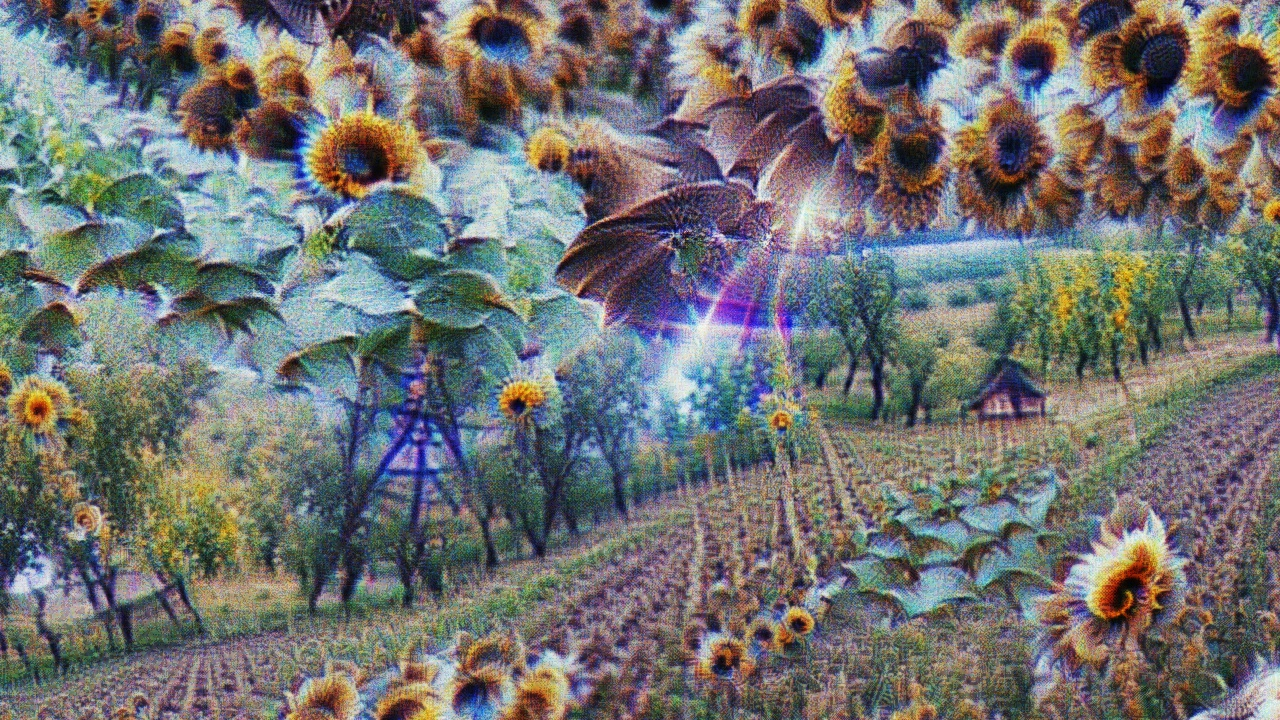

In [ ]:
#@title Generate

if aug_transform == 'elastic':
  trform_f = transforms.transforms_elastic
  sample_decrease *= 0.95
elif aug_transform == 'custom':
  trform_f = transforms.transforms_custom
  sample_decrease *= 0.95
elif aug_transform == 'fast':
  trform_f = transforms.transforms_fast
  sample_decrease *= 0.95
  print(' using fast aug transforms')
else:
  trform_f = transforms.normalize()

if enforce != 0:
  sample_decrease *= 0.5

samples = int(samples * sample_decrease)
print(' using %s method, %d samples, %s optimizer' % (method, samples, optimizer))

def enc_text(txt):
  if translate:
    txt = translator.translate(txt, dest='en').text
  emb = model_clip.encode_text(clip.tokenize(txt).cuda()[:77])
  return emb.detach().clone()

# Encode inputs
count = 0 # max count of texts and styles
key_txt_encs = [enc_text(txt) for txt in texts]
count = max(count, len(key_txt_encs))
key_styl_encs = [enc_text(style) for style in styles]
count = max(count, len(key_styl_encs))
assert count > 0, "No inputs found!"

# !rm -rf $tempdir
# os.makedirs(tempdir, exist_ok=True)

glob_steps = count * steps # saving
if glob_steps == frame_step: frame_step = glob_steps // 2 # otherwise no motion

outpic = ipy.Output()
outpic

params_tmp = params_tmp.detach()

# animation controls
if animate_them:
  if method == 'RGB':
    m_scale = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[-0.3])
    m_scale = 1 + (m_scale + 0.3) * zoom # only zoom in
  else:
    m_scale = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.6])
    m_scale = 1 - (m_scale-0.6) * zoom # ping pong
  m_shift = latent_anima([2], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.5,0.5])
  m_angle = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.5])
  m_shear = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.5])
  m_shift = (m_shift-0.5) * shift   * abs(m_scale-1.) / zoom
  m_angle = (m_angle-0.5) * rotate  * abs(m_scale-1.) / zoom
  m_shear = (m_shear-0.5) * distort * abs(m_scale-1.) / zoom

def get_encs(encs, num):
  cnt = len(encs)
  if cnt == 0: return []
  enc_1 = encs[min(num,   cnt-1)]
  enc_2 = encs[min(num+1, cnt-1)]
  return slerp(enc_1, enc_2, steps)

def frame_transform(img, size, angle, shift, scale, shear):
  if old_torch(): # 1.7.1
    img = T.functional.affine(img, angle, shift, scale, shear, fillcolor=0, resample=PIL.Image.BILINEAR)
    img = T.functional.center_crop(img, size)
    img = pad_up_to(img, size)
  else: # 1.8+
    img = T.functional.affine(img, angle, shift, scale, shear, fill=0, interpolation=T.InterpolationMode.BILINEAR)
    img = T.functional.center_crop(img, size) # on 1.8+ also pads
  return img

prev_enc = 0
def process(num):
  global params_tmp, opt_state, params, image_f, optimizer, pbar

  if interpolate_topics:
    txt_encs  = get_encs(key_txt_encs,  num)
    styl_encs = get_encs(key_styl_encs, num)
  else:
    txt_encs  = [key_txt_encs[min(num,  len(key_txt_encs)-1)][0]]  * steps if len(key_txt_encs)  > 0 else []
    styl_encs = [key_styl_encs[min(num, len(key_styl_encs)-1)][0]] * steps if len(key_styl_encs) > 0 else []

  if len(texts)  > 0: print(' ref text: ',  texts[min(num, len(texts)-1)][:80])
  if len(styles) > 0: print(' ref style: ', styles[min(num, len(styles)-1)][:80])

  for ii in range(steps):
    glob_step = num * steps + ii # saving/transforming

    # get encoded inputs
    txt_enc  = txt_encs[ii % len(txt_encs)].unsqueeze(0)   if len(txt_encs)  > 0 else None
    styl_enc = styl_encs[ii % len(styl_encs)].unsqueeze(0) if len(styl_encs) > 0 else None
    
    ### animation: transform frame, reload params

    h, w = sideY, sideX
    
    # transform frame for motion
    scale =       m_scale[glob_step]    if animate_them else 1-zoom
    trans = tuple(m_shift[glob_step])   if animate_them else [0, shift]
    angle =       m_angle[glob_step][0] if animate_them else rotate
    shear =       m_shear[glob_step][0] if animate_them else distort

    if method == 'RGB':
      if DepthStrength != 0:
        params_tmp = depth_transform(params_tmp, depth_infer, depth_mask, size, DepthStrength, scale, trans, colors, depthdir, glob_step)
      params_tmp = frame_transform(params_tmp, (h,w), angle, trans, scale, shear)
      params, image_f, _ = pixel_image([1,3,h,w], resume=params_tmp)
      img_tmp = None

    else: # FFT
      if old_torch(): # 1.7.1
        img_tmp = torch.irfft(params_tmp, 2, normalized=True, signal_sizes=(h,w))
        if DepthStrength != 0:
          img_tmp = depth_transform(img_tmp, depth_infer, depth_mask, size, DepthStrength, scale, trans, colors, depthdir, glob_step)
        img_tmp = frame_transform(img_tmp, (h,w), angle, trans, scale, shear)
        params_tmp = torch.rfft(img_tmp, 2, normalized=True)
      else: # 1.8+
        if type(params_tmp) is not torch.complex64:
          params_tmp = torch.view_as_complex(params_tmp)
        img_tmp = torch.fft.irfftn(params_tmp, s=(h,w), norm='ortho')
        if DepthStrength != 0:
          img_tmp = depth_transform(img_tmp, depth_infer, depth_mask, size, DepthStrength, scale, trans, colors, depthdir, glob_step)
        img_tmp = frame_transform(img_tmp, (h,w), angle, trans, scale, shear)
        params_tmp = torch.fft.rfftn(img_tmp, s=[h,w], dim=[2,3], norm='ortho')
        params_tmp = torch.view_as_real(params_tmp)

      params, image_f, _ = fft_image([1,3,h,w], resume=params_tmp, sd=1.)

    image_f = to_valid_rgb(image_f, colors=colors)
    del img_tmp

    if optimizer.lower() == 'adamw':
      optimr = torch.optim.AdamW(params, learning_rate, weight_decay=0.01, amsgrad=True)
    elif optimizer.lower() == 'adamw_custom':
      optimr = torch.optim.AdamW(params, learning_rate, weight_decay=0.01, amsgrad=True, betas=(.0,.999))
    elif optimizer.lower() == 'adam':
      optimr = torch.optim.Adam(params, learning_rate)
    else: # adam_custom
      optimr = torch.optim.Adam(params, learning_rate, betas=(.0,.999))

    if smooth is True and num + ii > 0:
      optimr.load_state_dict(opt_state)

    ### optimization

    for ss in range(save_step):
      loss = 0

      noise = aug_noise * (torch.rand(1, 1, *params[0].shape[2:4], 1)-0.5).cuda() if aug_noise > 0 else 0.
      img_out = image_f(noise, fixcontrast=resume)
      img_sliced = slice_imgs([img_out], samples, modsize, trform_f, align, macro)[0]
      out_enc = model_clip.encode_image(img_sliced)

      if method == 'RGB': # empirical hack
        loss += abs(img_out.mean((2,3)) - 0.45).mean() # fix brightness
        loss += abs(img_out.std((2,3)) - 0.17).sum() # fix contrast

      if txt_enc is not None:
        loss -= sim_func(txt_enc, out_enc, similarity_function)
      if styl_enc is not None:
        loss -= style_power * sim_func(styl_enc, out_enc, similarity_function)
      if sharpness != 0: # mode = scharr|sobel|naive
        loss -= sharpness * derivat(img_out, mode='naive')
        # loss -= sharpness * derivat(img_sliced, mode='scharr')
      if enforce != 0:
        img_sliced = slice_imgs([image_f(noise, fixcontrast=resume)], samples, modsize, trform_f, align, macro)[0]
        out_enc2 = model_clip.encode_image(img_sliced)
        loss -= enforce * sim_func(out_enc, out_enc2, similarity_function)
        del out_enc2; torch.cuda.empty_cache()
      if expand > 0:
        global prev_enc
        if ii > 0:
          loss += expand * sim_func(prev_enc, out_enc, similarity_function)
        prev_enc = out_enc.detach().clone()
      del img_out, img_sliced, out_enc; torch.cuda.empty_cache()

      optimr.zero_grad()
      loss.backward()
      optimr.step()
    
    ### save params & frame

    params_tmp = params[0].detach().clone()
    if smooth is True:
      opt_state = optimr.state_dict()

    with torch.no_grad():
      img_t = image_f(contrast=contrast, fixcontrast=resume)[0].permute(1,2,0)
      img_np = torch.clip(img_t*255, 0, 255).cpu().numpy().astype(np.uint8)
    imageio.imsave(os.path.join(tempdir, '%05d.jpg' % glob_step), img_np, quality=95)
    shutil.copy(os.path.join(tempdir, '%05d.jpg' % glob_step), 'result.jpg')
    outpic.clear_output()
    with outpic:
      display(Image('result.jpg'))
    del img_t
    pbar.upd()

  params_tmp = params[0].detach().clone()

outpic = ipy.Output()
outpic

pbar = ProgressBar(glob_steps)
for i in range(count):
  process(i)

HTML(makevid(tempdir))
files.download(tempdir + '.mp4')

if save_depth and DepthStrength != 0:
  HTML(makevid(depthdir))
  files.download(depthdir + '.mp4')

If video is not auto-downloaded after generation (for whatever reason), run this cell to do that:

In [ ]:
files.download(tempdir + '.mp4')
if save_depth and DepthStrength != 0:
  files.download(depthdir + '.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>